In [1]:
#Import libraries

import os
import re
import shutil
import string
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch import nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.metrics import f1_score 

In [2]:
# converting return value from list to string

def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))])

    return text2.lower()
  #print('cleaned:'+text1)

In [5]:
#Upload and process Dataset
train_data= pd.read_csv("../data/training/TRAINING/training.csv", sep="\t") # Put your path to training.csv here
train_data.dropna(axis = 0, how ='any',inplace=True)
train_data['Num_words_text'] = train_data['Text Transcription'].apply(lambda x:len(str(x).split()))
train_data['text'] = train_data['Text Transcription']
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]

print('-------Train data--------')
print(train_data['misogynous'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()



train_data['text'] = train_data['text'].apply(clean_text)
mask.sum()

-------Train data--------
1    4982
0    4964
Name: misogynous, dtype: int64
9946
-------------------------


9946

In [6]:
#Text after pre-processing

train_data[['text', 'Text Transcription']]

,text,Text Transcription
1,roses are red violets are blue you dont say ye...,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,breaking news russia releases photo donald tru...,BREAKING NEWS: Russia releases photo of DONALD...
3,man seeking woman ignad,MAN SEEKING WOMAN Ignad 18 O
4,explaining the deep lore jrr tolkeins world ar...,Me explaining the deep lore of. J.R.R. Tolkein...
5,pictophle app straight white malle starts talk...,PICTOPHLE APP *Straight white malle starts tal...
...,...,...
9995,waiting for the end the covid imgflipcom,WAITING FOR THE END OF THE COVID imgflip.com
9996,smart women are around imgflipcom,SMART WOMEN ARE AROUND imgflip.com
9997,good girls are behind the corner imgflipcom,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,cooking for wife imgflipcom,COOKING FOR MY WIFE imgflip.com


In [7]:


train_data['label'] = train_data['misogynous']

test_data= pd.read_csv("../data/trial/Users/fersiniel/Desktop/MAMI - TO LABEL/TRIAL DATASET/trial.csv",sep="\t") #put you path to trial.csv here
test_data.dropna(axis = 0, how ='any',inplace=True)
test_data['Num_words_text'] = test_data['Text Transcription'].apply(lambda x:len(str(x).split()))

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['misogynous'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['text']=test_data['Text Transcription']
test_data['text'] = test_data['text'].apply(clean_text)


test_data['label'] = test_data['misogynous']
print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

-------Test data--------
0    56
1    43
Name: misogynous, dtype: int64
99
-------------------------
Train Max Sentence Length :269
Test Max Sentence Length :30


In [8]:
#merge
train_data=train_data.append(test_data,ignore_index=True)

/tmp/ipykernel_56453/2497328984.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data=train_data.append(test_data,ignore_index=True)


In [9]:
X_train, X_valid, Y_train, Y_valid= train_test_split(train_data['text'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)

print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(Y_train)))


print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(Y_valid)))

print('Test data len:'+str(len(test_data['text'].tolist())))
print('Class distribution'+ str(Counter(test_data['label'].tolist())))


train_dat =list(zip(Y_train,X_train))
valid_dat =list(zip(Y_valid,X_valid))
test_dat=list(zip(test_data['label'].tolist(),test_data['text'].tolist()))

Train data len:8036
Class distributionCounter({1: 4020, 0: 4016})
Valid data len:2009
Class distributionCounter({1: 1005, 0: 1004})
Test data len:99
Class distributionCounter({0: 56, 1: 43})


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
#Tokenize

tokenizer = get_tokenizer('basic_english')
train_iter = train_dat
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [12]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [13]:
text_pipeline('here is the an example')

[133, 0, 1, 0, 3052]

In [14]:
label_pipeline('1')

1

In [15]:
#Create batces

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

#train_iter =train_dat
#dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [16]:
#Model

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc1 = nn.Linear(embed_dim,64)
        self.fc2 = nn.Linear(64,16)
        self.fc3 = nn.Linear(16, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()
        self.fc3.weight.data.uniform_(-initrange, initrange)
        self.fc3.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        x = F.relu(self.fc1(embedded))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
#Initialize model

train_iter1 = train_dat
num_class = len(set([label for (label, text) in train_iter1]))
print(num_class)
vocab_size = len(vocab)
emsize = 128
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

2


In [18]:
#Training

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count



# Hyperparameters

EPOCHS = 10 # epoch
LR =10  # learning rate
BATCH_SIZE = 16 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_iter2 = train_dat
test_iter2 =test_dat
valid_iter2= valid_dat




train_dataloader = DataLoader(train_iter2, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_iter2, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter2, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)
val_acc = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    val_acc.append(accu_val)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


| epoch   1 |   500/  503 batches | accuracy    0.509
-----------------------------------------------------------
| end of epoch   1 | time:  3.28s | valid accuracy    0.500 
-----------------------------------------------------------
| epoch   2 |   500/  503 batches | accuracy    0.654
-----------------------------------------------------------
| end of epoch   2 | time:  3.14s | valid accuracy    0.712 
-----------------------------------------------------------
| epoch   3 |   500/  503 batches | accuracy    0.728
-----------------------------------------------------------
| end of epoch   3 | time:  2.50s | valid accuracy    0.734 
-----------------------------------------------------------
| epoch   4 |   500/  503 batches | accuracy    0.781
-----------------------------------------------------------
| end of epoch   4 | time:  1.95s | valid accuracy    0.732 
-----------------------------------------------------------
| epoch   5 |   500/  503 batches | accuracy    0.845
------

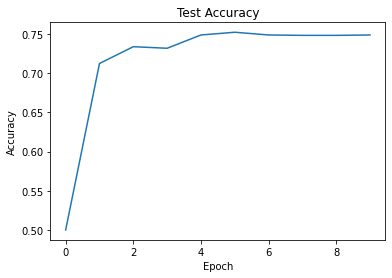

In [19]:
plt.plot(val_acc)
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [20]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.899


In [21]:
test_data = pd.read_csv("../data/test/Test.csv",sep="\t") # Put your path to Test.csv here
test_data['text'] = test_data['Text Transcription'].apply(clean_text)
test_data

,file_name,Text Transcription,text
0,15236.jpg,FACEBOOK SINGLES GROUPS BELIKE WHEN A NEW WOMA...,facebook singles groups belike when new woman ...
1,15805.jpg,"SO, IF YOU'RE A FEMINIST HOW CAN YOU EAT DAIRY?",youre feminist how can you eat dairy
2,16254.jpg,WHEN A CUTE GIRL LEFT YOUR MESSAGE ON SEEN,when cute girl left your message seen
3,16191.jpg,Photographing something you want to show every...,photographing something you want show everyone...
4,15952.jpg,HEY BABE CAN YOU MAKE ME A SANDWICH? Hey babe ...,hey babe can you make sandwich hey babe can yo...
...,...,...,...
995,15591.jpg,IT'S NOT YOUR FAULT You didn't design the dres...,its not your fault you didnt design the dressy...
996,15049.jpg,THINK ABOUT HOW MUCH BETTER HER SKIN IS BREATH...,think about how much better her skin breathing...
997,15363.jpg,THE STEREOTYPES ARE TRUE F SHE DOES HAVE A TIG...,the stereotypes are true she does have tight p...
998,15199.jpg,DRAWS NAKED PICTURES OF BLACK WOMEN 00 0000 GE...,draws naked pictures black women gets mad when...


In [22]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

pred = []
errors = 0
for i, text in enumerate(test_data['text']):
    try:
        ex_text_str = text
        model = model.to("cpu")
        print(predict(ex_text_str, text_pipeline),i)
        pred.append(predict(ex_text_str, text_pipeline))
    except RuntimeError:
        print('Opa!')
        errors += 1
        pred.append(0)

pred = np.array(pred)

1 0
1 1
1 2
1 3
1 4
0 5
1 6
0 7
1 8
1 9
0 10
1 11
1 12
0 13
0 14
0 15
0 16
0 17
1 18
0 19
0 20
1 21
0 22
0 23
0 24
1 25
1 26
1 27
1 28
1 29
1 30
0 31
0 32
0 33
0 34
1 35
0 36
0 37
0 38
1 39
1 40
0 41
1 42
0 43
1 44
1 45
1 46
0 47
1 48
1 49
0 50
1 51
1 52
1 53
1 54
0 55
1 56
0 57
0 58
1 59
0 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
0 69
1 70
1 71
1 72
1 73
1 74
0 75
1 76
1 77
0 78
1 79
1 80
1 81
0 82
0 83
1 84
1 85
1 86
0 87
1 88
1 89
1 90
0 91
0 92
0 93
1 94
0 95
0 96
1 97
1 98
0 99
1 100
1 101
1 102
1 103
0 104
1 105
1 106
1 107
0 108
1 109
1 110
1 111
1 112
1 113
0 114
1 115
1 116
0 117
1 118
0 119
1 120
1 121
1 122
0 123
0 124
1 125
1 126
1 127
1 128
0 129
1 130
0 131
1 132
1 133
1 134
1 135
1 136
0 137
1 138
0 139
0 140
0 141
0 142
1 143
0 144
0 145
0 146
0 147
1 148
1 149
1 150
0 151
1 152
1 153
1 154
1 155
0 156
0 157
0 158
0 159
1 160
0 161
0 162
0 163
0 164
0 165
1 166
0 167
1 168
0 169
1 170
1 171
0 172
1 173
1 174
1 175
1 176
1 177
0 178
1 179
0 180
0 181
0 182
0 183
1 184


In [23]:
import pickle as pkl

arrayInput = pred
fileName = "text_output.pkl"
fileObject = open(fileName, 'wb')
pkl.dump(arrayInput, fileObject)
fileObject.close()